## Chapter 3: Image Segmentation

### Problems

1. Human Skin Segmentation with binary classifiers with `scikit-learn`
2. Segmentation by labelling connected components with `scikit-image`       
3. Foreground-backgroud Separation  in a Video using GMM with `opencv-python`
4. Semantic Segmentation    
    4.1 using pretrained DeepLabV3+ XCeptionNet model with `tensorflow`        
    4.2 with `opencv-python` and pretrained-caffe ENet model    
5. Panoptic Segmentation with the Deep learning model `Detectron2`
6. Blurring and Changing Background in Image / Video using `DeeplabV3`
7. Outlier Detection using AutoEncoder with `H2O`

### Problem 1: Human Skin Segmentation with binary classifiers with `scikit-learn`

![](images/skin_table.png)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from skimage.io import imread
from skimage.color import rgb2ycbcr, gray2rgb
    
df = pd.read_csv('images/Skin_NonSkin.txt', header=None, delim_whitespace=True)
df.columns = ['B', 'G', 'R', 'skin']
df.skin[df.skin == 2] = 0
df['Cb'] = np.round(128 -.168736*df.R -.331364*df.G + .5*df.B).astype(int)
df['Cr'] = np.round(128 +.5*df.R - .418688*df.G - .081312*df.B).astype(int)
df.drop(['B','G','R'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)
df.head()

In [15]:
Xy = df.values
X = Xy[:, 1:]
y = Xy[:, 0]
#print(X.shape, y.shape, len(y[y==0]), len(y[y==1]))

models = (GradientBoostingClassifier(n_estimators=1000, max_leaf_nodes=4, max_depth=None, random_state=2,
                   min_samples_split=5),
          DecisionTreeClassifier(random_state=0),
          GaussianNB(),
          KNeighborsClassifier(5))
models = [clf.fit(X, y) for clf in models]

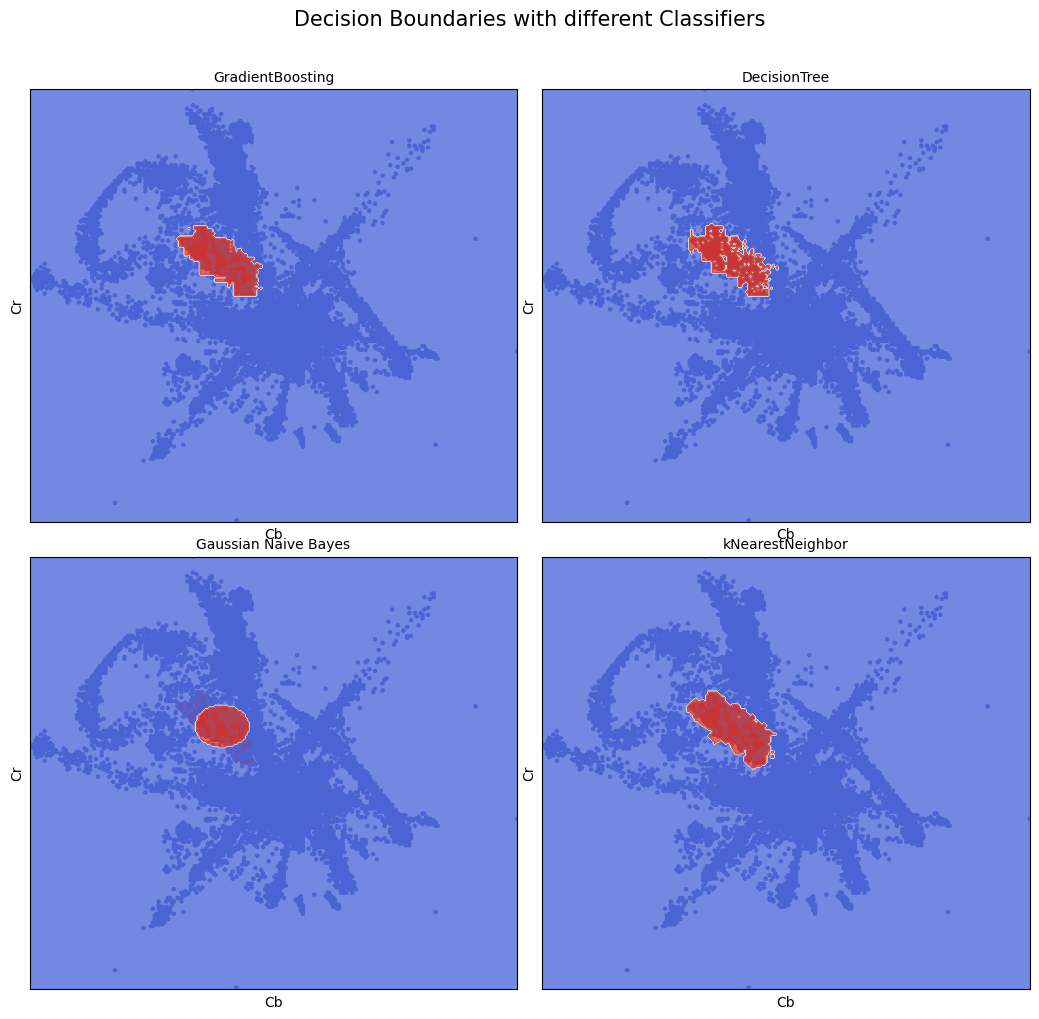

In [16]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.9, wspace=0.05, hspace=0.08)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1, h=1)

# title for the plots
titles = ('GradientBoosting',
          'DecisionTree',
          'Gaussian Naive Bayes',
          'kNearestNeighbor')

for clf, title, ax in zip(models, titles, sub.flatten()):
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=5) #, edgecolors='k')
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Cb', size=10)
    ax.set_ylabel('Cr', size=10)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title, size=10)

plt.suptitle('Decision Boundaries with different Classifiers', size=15)
plt.show()

GradientBoosting
DecisionTree
Gaussian Naive Bayes
kNearestNeighbor


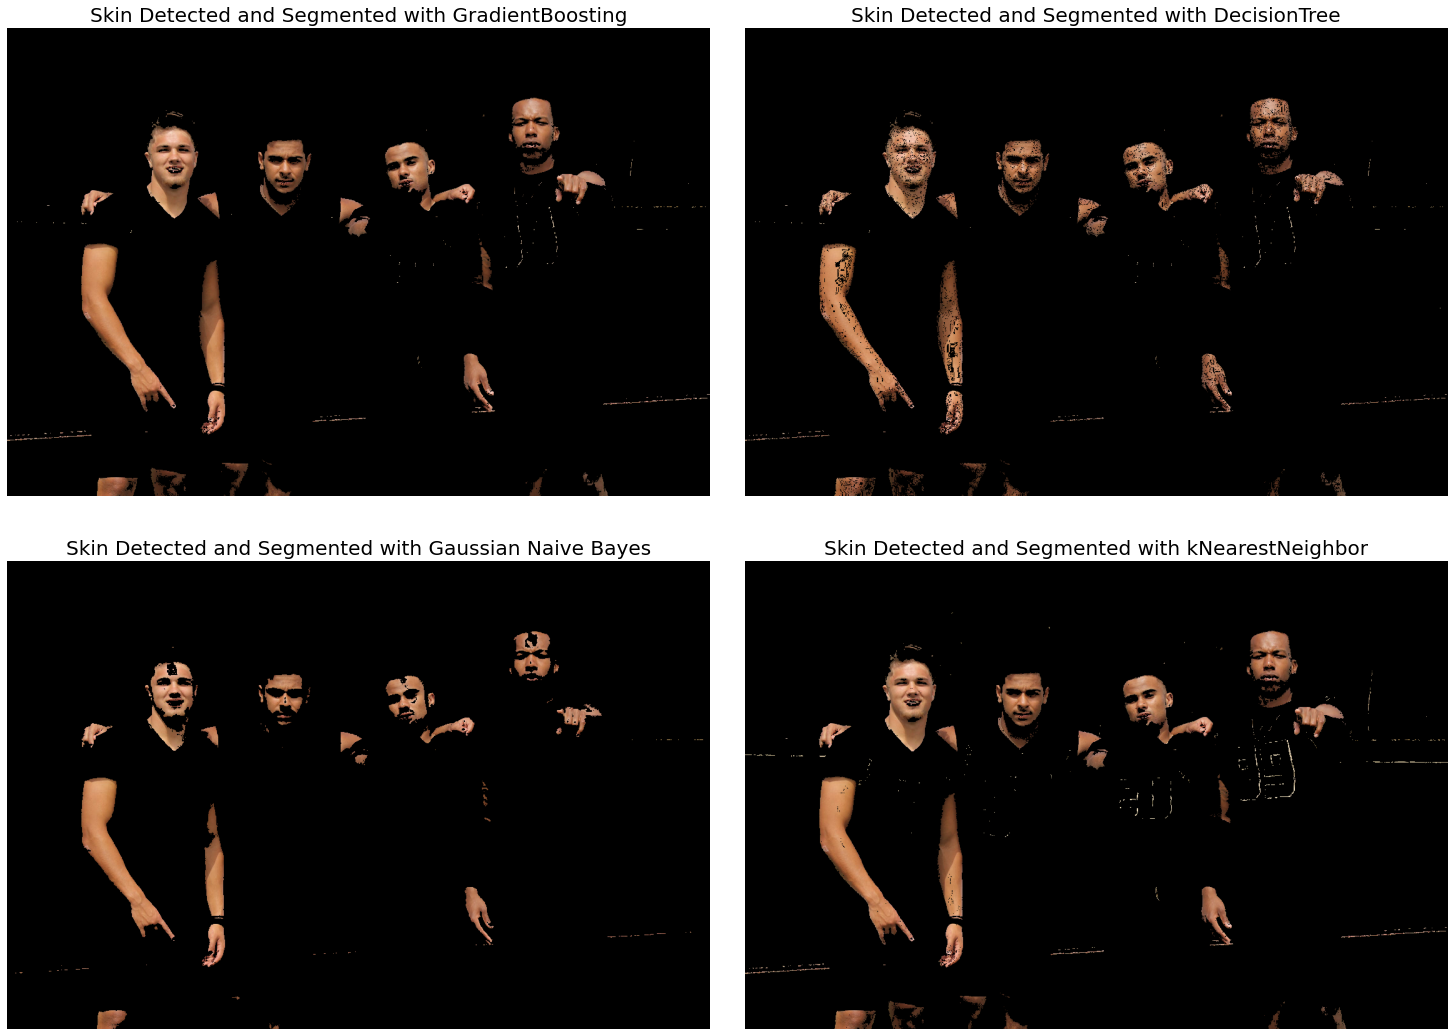

In [155]:
image = imread('images/Img_03_12.png')[...,:3]
proc_image = np.reshape(rgb2ycbcr(image), (-1, 3))

fig, sub = plt.subplots(2, 2, figsize=(20,15))
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0.08)

for clf, title, ax in zip(models, titles, sub.flatten()):
    print(title)
    skin = clf.predict(proc_image[...,1:])
    skin = skin.reshape(image.shape[0], image.shape[1])
    result = np.bitwise_and(gray2rgb(255*skin).astype(np.uint8), image)
    ax.imshow(result), ax.axis('off'), ax.set_title('Skin Detected and Segmented with ' + title, size=20)
plt.show()

### Problem 2: Segmentation by labelling connected components with `scikit-image`

1482


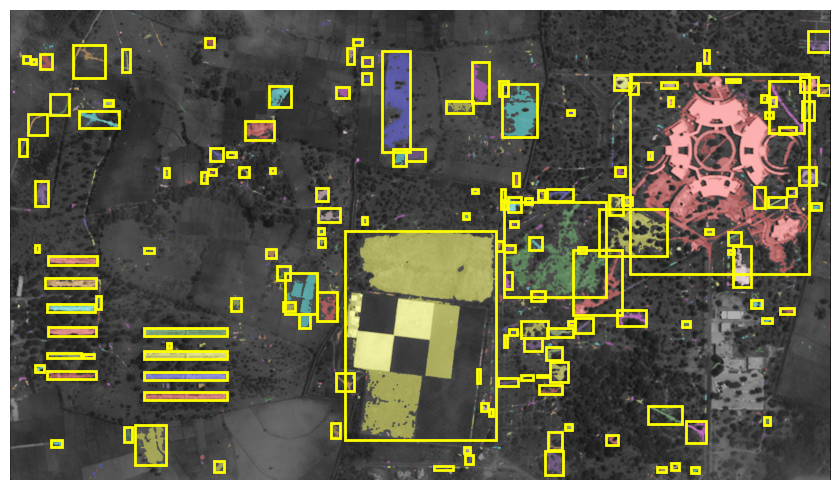

In [18]:
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb, rgb2gray
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

image = (255*rgb2gray(imread('images/Img_03_13.png')[...,:3])).astype(np.uint8)

thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

cleared = clear_border(bw)

label_image = label(cleared, connectivity=2)
image_label_overlay = label2rgb(label_image, image=image)
print(np.max(label_image))

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(image_label_overlay, cmap='jet')

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100: # and region.area <= 80000:
        # draw rectangle around segmented regions
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='yellow', linewidth=2)
        #print('Label: {} >> Object size: {}'.format(region.label, region.area))
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

* By default $0$-valued pixel in the binary image are considered as background pixel, by the `skimage.measure.label()` function. You can override this default behavior by passing a value in the `background` argument (e.g., `background=1` will consider the $1$ valued pixels as background). 
* Use the input image of the school building and obtain different segementation results by varying the threshold for binarization, `background` value and color map (`cmap`) for `matplotlib.pylab.imshow()`. You should obtain a figure like the following one.

![](images/bghs.png)

### Problem 3: Foreground-backgroud Separation in a Video using GMM with `opencv-python`

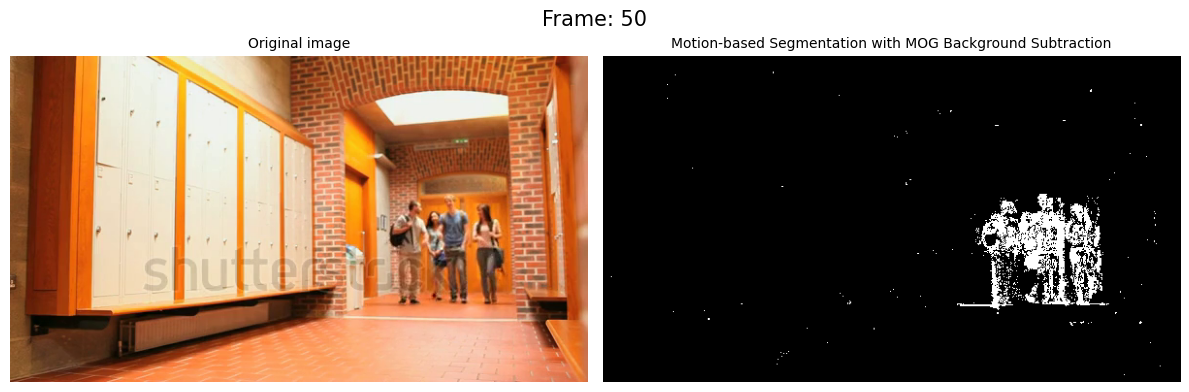

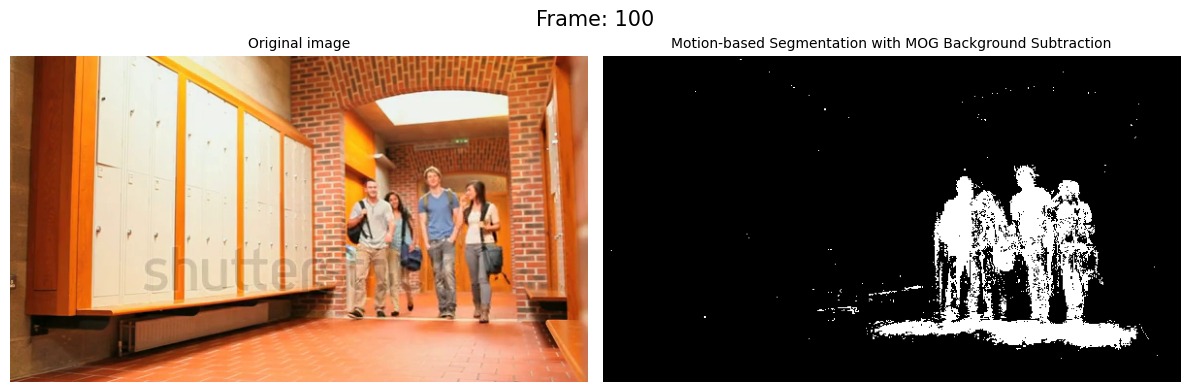

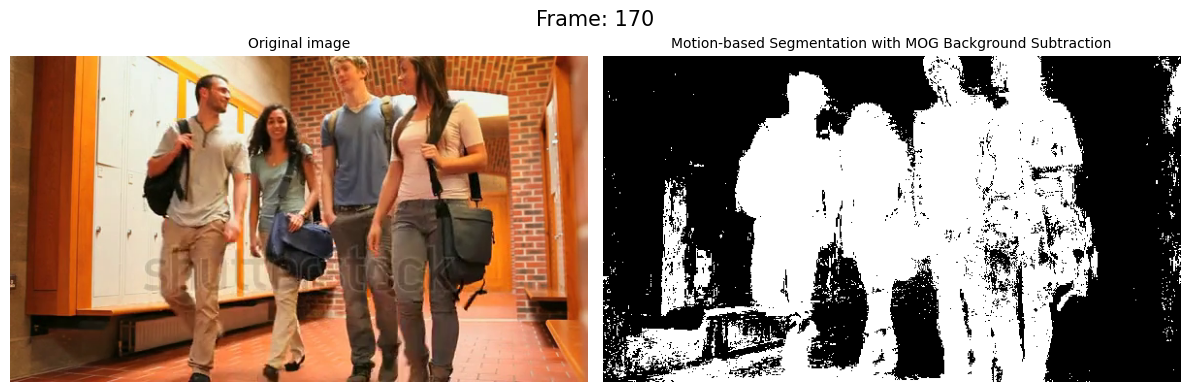

In [22]:
import numpy as np
import cv2
import matplotlib.pylab as plt

cap = cv2.VideoCapture('images/Vid_03_01.mp4') 
foreground_background = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=32, detectShadows=False)

count = 1
while True:    
    _, frame = cap.read()    
    if frame is None:
        break        
    frame = frame.astype(np.uint8)     
    foreground_mask = foreground_background.apply(frame).astype(np.uint8)
    #print(foreground_mask.shape, np.max(foreground_mask), np.min(foreground_mask), np.mean(foreground_mask))    
    if count in [50, 100, 170]:
        plt.figure(figsize=(12,4))
        plt.gray()
        plt.subplot(121), plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original image', size=10)
        plt.subplot(122), plt.imshow(foreground_mask), plt.axis('off'), plt.title('Motion-based Segmentation with MOG Background Subtraction', size=10)
        plt.suptitle('Frame: ' + str(count), size=15)
        plt.tight_layout()
        plt.show()    
    count += 1           

cap.release()

### Problem 4: Semantic Segmentation 

### 4.1 using pretrained DeepLabV3+  XCeptionNet model with tensorflow

In [161]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pylab as plt
from matplotlib import gridspec
#import tensorflow
#tensorflow.__version__
# 2.13.0
import tensorflow.compat.v1 as tf
from tensorflow.io.gfile import GFile

def label_to_color_image(label):
    
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

label_names = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

full_label_map = np.arange(len(label_names)).reshape(len(label_names), 1)
full_color_map = label_to_color_image(full_label_map)

def visualize_segmentation(image, seg_map):
  plt.figure(figsize=(20, 15))
  plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0.05)
  plt.subplot(221), plt.imshow(image), plt.axis('off'), plt.title('input image', size=20)
  plt.subplot(222)
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image), plt.axis('off'), plt.title('segmentation map', size=20)
  plt.subplot(223), plt.imshow(image), plt.imshow(seg_image, alpha=0.7), plt.axis('off'), plt.title('segmentation overlay', size=20)
  unique_labels = np.unique(seg_map)
  ax = plt.subplot(224)
  plt.imshow(full_color_map[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right(), plt.yticks(range(len(unique_labels)), label_names[unique_labels]), plt.xticks([], [])
  ax.tick_params(width=0.0, labelsize=20), plt.grid('off')
  plt.show()

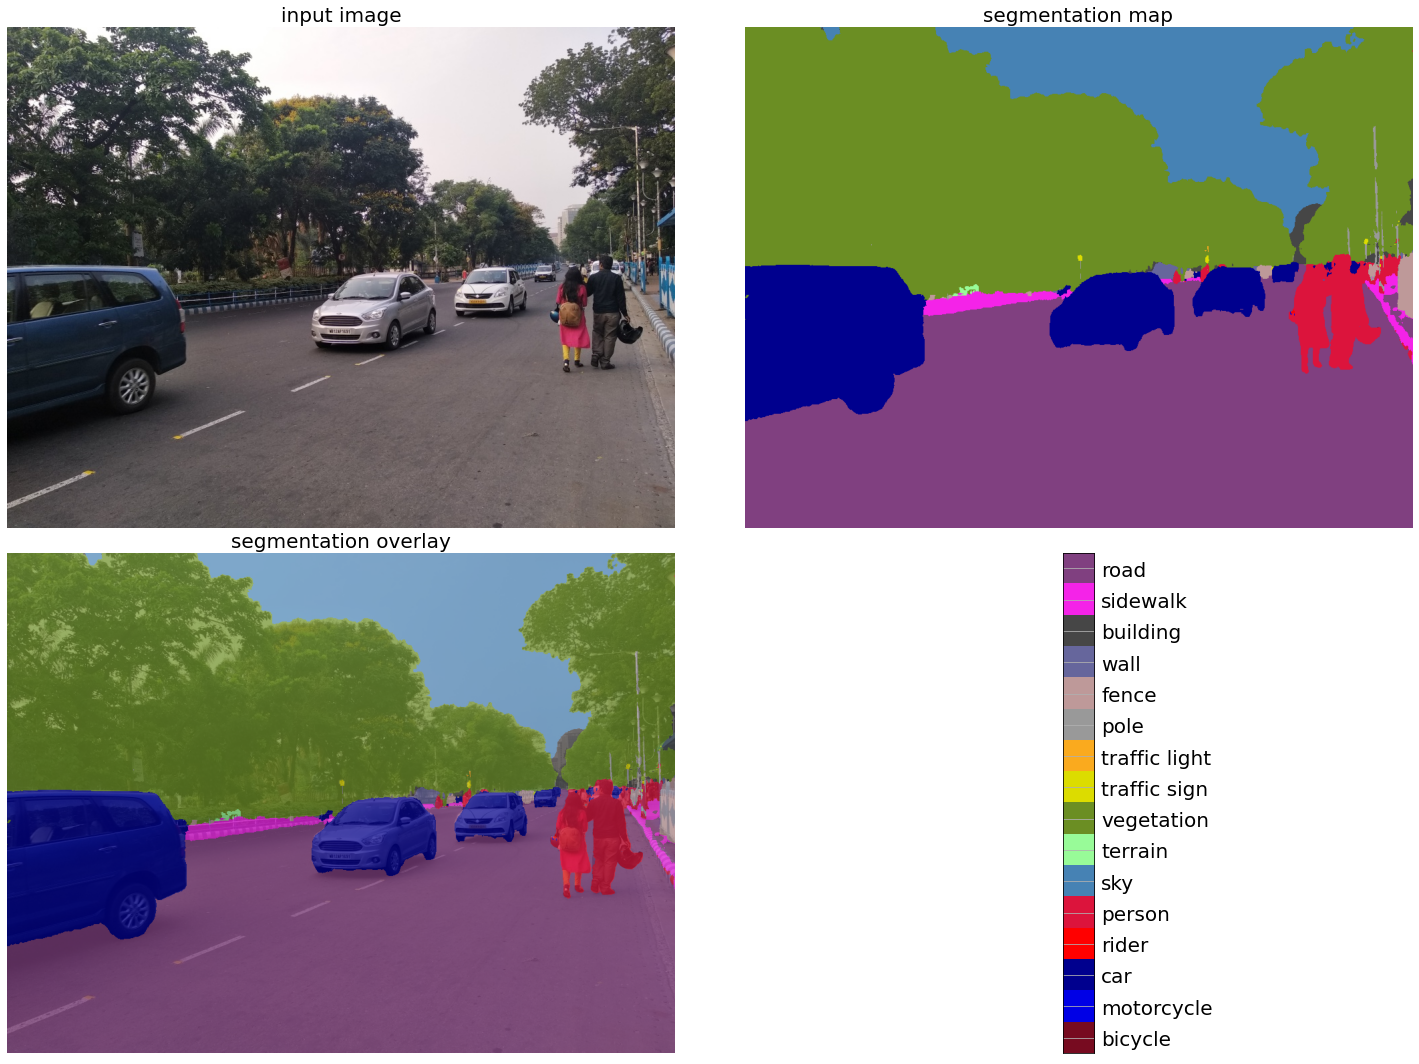

In [163]:
def run_semantic_segmentation(image, model_path):
    graph = tf.Graph()
    graph_def = None
    with GFile(model_path, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    if graph_def is None:
        raise RuntimeError('Cannot find inference graph in tar archive.')
    with graph.as_default():
        tf.import_graph_def(graph_def, name='')
    sess = tf.Session(graph=graph)
    width, height = image.size
    target_size = (2049,1025)  # size of Cityscapes images
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = sess.run('SemanticPredictions:0',
            feed_dict={'ImageTensor:0': [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]  # expected batch size = 1
    if len(seg_map.shape) == 2:
        seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
    seg_map = cv2.resize(seg_map, (width,height), interpolation=cv2.INTER_NEAREST)    
    return seg_map

model = 'models/frozen_inference_graph.pb'
image = 'images/Img_03_16.png'
image = Image.open(image)
seg_map = run_semantic_segmentation(image, model)
visualize_segmentation(image, seg_map)

### 4.2 with `opencv-python` and pretrained-caffe ENet model

In [8]:
# import the necessary packages
# pip install imutils
import numpy as np
import imutils
import time
import cv2
import matplotlib.pylab as plt

classes = open('models/enet-classes.txt').read().strip().split("\n")
colors = open('models/enet-colors.txt').read().strip().split("\n")
colors = [np.array(c.split(",")).astype("int") for c in colors]
colors = np.array(colors, dtype="uint8")

In [9]:
legend = np.zeros(((len(classes) * 25) + 25, 300, 3), dtype="uint8")
for (i, (className, color)) in enumerate(zip(classes, colors)):
    color = [int(c) for c in color]
    cv2.putText(legend, className, (5, (i * 25) + 17), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv2.rectangle(legend, (100, (i * 25)), (300, (i * 25) + 25), tuple(color), -1)

In [10]:
net = cv2.dnn.readNet('models/enet-model.net')

image = cv2.imread('images/Img_03_21.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = imutils.resize(image, width=500)
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (1024, 512), 0, swapRB=True, crop=False)

net.setInput(blob)
start = time.time()
output = net.forward()
end = time.time()

(numClasses, height, width) = output.shape[1:4]
classMap = np.argmax(output[0], axis=0)
mask = colors[classMap]

mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
classMap = cv2.resize(classMap, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

output = ((0.4 * image) + (0.6 * mask)).astype("uint8")
#legend = imutils.resize(legend,  height=output.shape[0])

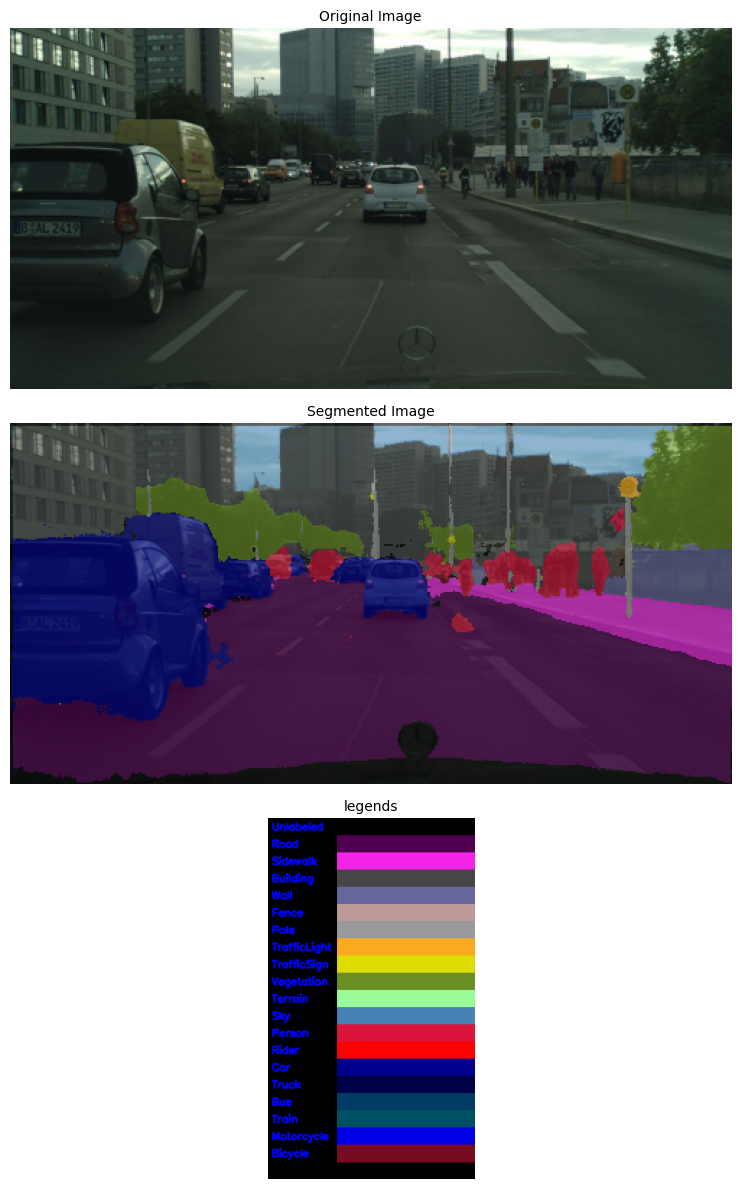

In [12]:
plt.figure(figsize=(10,12))
plt.subplot(311), plt.imshow(image), plt.axis('off'), plt.title('Original Image', size=10)
plt.subplot(312), plt.imshow(output), plt.axis('off'), plt.title('Segmented Image', size=10)
plt.subplot(313), plt.imshow(legend), plt.axis('off'), plt.title('legends', size=10)
plt.tight_layout()
plt.show()

### Problem 5: Panoptic Segmentation with the Deep learning model `Detectron2`

In [ ]:
# must be run in colab with runtime type GPU
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
#print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

# import some common libraries
import numpy as np
import matplotlib.pylab as plt
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)

In [ ]:
im = cv2.imread('Img_03_16.jpg')

panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.9)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)

im = im[:, :, ::-1]
out = out.get_image()[:, :, ::-1]
plt.figure(figsize=(20,10))
plt.subplot(121), plt.imshow(im), plt.axis('off'), plt.title('input image', size=20)
plt.subplot(122), plt.imshow(out), plt.axis('off'), plt.title('Panoptic Segmented + overlayed', size=20)
plt.tight_layout()
plt.show()

<div>
<img src="images/panoptic_out.png" width="1000"/>
</div>

### Problem 6: Blurring and Changing Background in Image / Video using `DeeplabV3`

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

In [2]:
def load_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
    model.to(device).eval()
    return model

def get_pred(img, model):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    imagenet_stats = [[0.485, 0.456, 0.406], [0.485, 0.456, 0.406]]
    preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.Normalize(mean = imagenet_stats[0],
                                                                                  std  = imagenet_stats[1])])
    input_tensor = preprocess(img).unsqueeze(0)
    input_tensor = input_tensor.to(device)
    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        output = output.argmax(0)

    return output.cpu().numpy()

Using cache found in C:\Users\sandi/.cache\torch\hub\pytorch_vision_v0.6.0


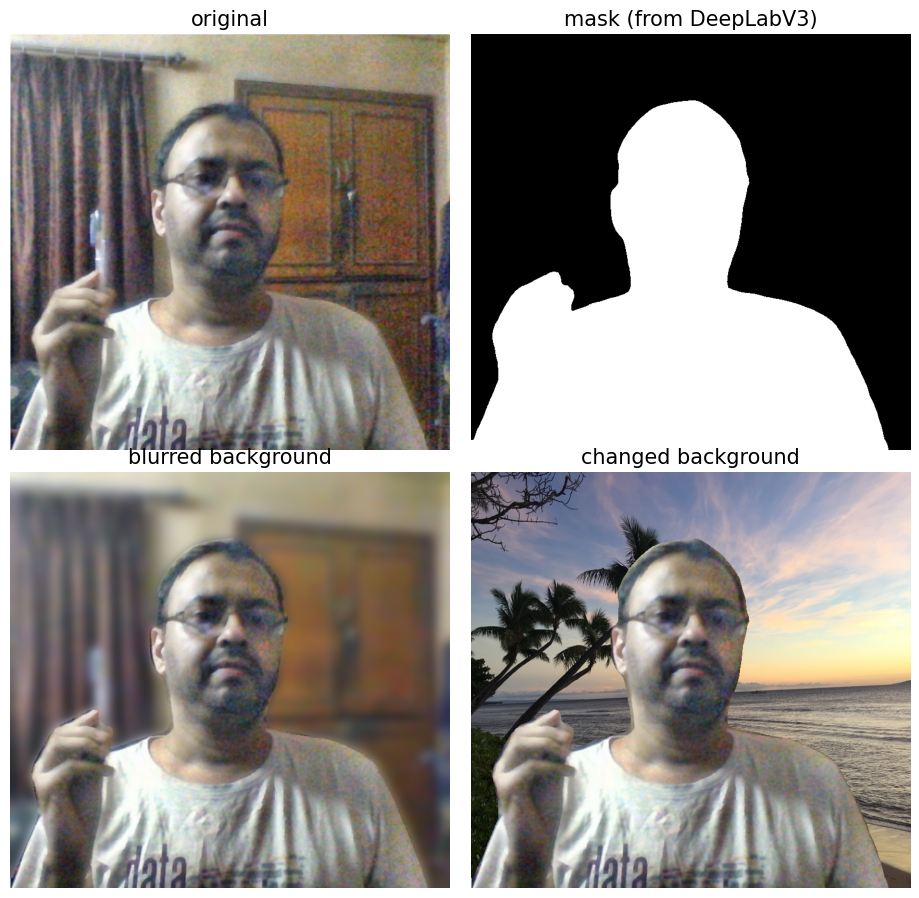

In [5]:
model = load_model()

orig = cv2.cvtColor(cv2.imread('images/Img_03_23.png'), cv2.COLOR_BGR2RGB)
frame = orig.copy()
width, height, channels = frame.shape

bg_image = cv2.imread('images/Img_03_23.jpg')
bg_image = cv2.cvtColor(bg_image, cv2.COLOR_BGR2RGB)

labels = get_pred(frame, model)

mask = labels == 0 # background
mask = np.repeat(mask[:, :, np.newaxis], channels, axis = 2)
blur_value = (51, 51)
blur = cv2.GaussianBlur(frame, blur_value, 0)
frame[mask] = blur[mask]

mask = labels == 15 # person
mask = np.repeat(mask[:, :, np.newaxis], 3, axis = 2)
bg = cv2.resize(bg_image, (height, width))
bg[mask] = frame[mask]
out_frame = bg

plt.figure(figsize=(9,9))
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
plt.subplot(221), plt.imshow(orig), plt.axis('off'), plt.title('original', size=15)
plt.subplot(223), plt.imshow(frame), plt.axis('off'), plt.title('blurred background', size=15)
plt.subplot(222), plt.imshow(labels, cmap='gray'), plt.axis('off'), plt.title('mask (from DeepLabV3)', size=15)
plt.subplot(224), plt.imshow(out_frame), plt.axis('off'), plt.title('changed background', size=15)
plt.show()

### Problem 7: Outlier Detection using AutoEncoder with `H2O`

In [ ]:
# pip install h2o

import numpy as np
import matplotlib.pylab as plt
import h2o
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator

h2o.init()
# Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
# Attempting to start a local H2O server...

In [ ]:
resp = 784
train = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/mnist/train.csv.gz")
test = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/mnist/test.csv.gz")
train.pop(resp)
test.pop(resp)

In [ ]:
ae_model = H2OAutoEncoderEstimator(activation="Tanh",
                                   hidden=[64,32,64], #[nfeatures],
                                   model_id="ae_model",
                                   epochs=25,
                                   ignore_const_cols=False,
                                   reproducible=True,
                                   seed=1234)
ae_model.train(list(range(resp)), training_frame=train)
ae_model.mse()
# 0.016211654087278905

In [ ]:
pred = ae_model.predict(test)
test_rec_error = ae_model.anomaly(test)
test_rec_error = test_rec_error.as_data_frame().values
test_rec_error = test_rec_error.ravel()
indices = np.argsort(test_rec_error)[::-1]

In [ ]:
# Top k outliers
k = 8 #100
test_images = test.as_data_frame().values
pred_images = pred.as_data_frame().values
for i in range(k):
    idx = indices[i]
    k += 1
    plt.figure(figsize=(10,7))
    plt.gray()  
    plt.subplot(121), plt.imshow(test_images[idx].reshape(28,28)), plt.axis('off'), plt.title('original', size=10)
    plt.subplot(122), plt.imshow(pred_images[idx].reshape(28,28)), plt.axis('off'), plt.title('reconstructed, loss:{:.03f}'.format(test_rec_error[idx]), size=10)
    plt.tight_layout()
    plt.show()

#### Top Outliers detected with the AutoEncoder (with high reconstruction errors)

![](images/Img_03_27.png)

#### Images with less reconstruction error (low outlier scores) with the AutoEncoder

![](images/Img_03_28.png)

## Questions

1. **Training a U-Net model on Self-Driving Cars dataset**: The U-Net architecture is a convolutional neural network (CNN) designed for semantic segmentation tasks in computer vision. It is characterized by its U-shaped structure, which consists of a contracting path (Encoder) followed by an expansive path (Decoder). Build an UNet architechture `unet_model` (hint: understand the building blocks and use the following code), by reusing `conv_block` and `upsampling_block` components, define with `keras` functional API. 

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=None)     
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv) 
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

Use the `CameraRGB` dataset from `lyft-udacity-challenge` (self-driving cars dataset) to train the UNet model (which contains training images along with annotated ground-truth segmentation labels). Finally, use predict to segment the test images. You should obtain better quality segmentation with higher epochs, as shown for a few sample test images.

![](images/Img_03_24.png)
![](images/Img_03_25.png)
![](images/Img_03_26.png)

7. Use the `Detectron2` pretrained model to run **instance segmentation** and compare **instance** vs. **panoptic segmentation** using the input image used earlier. You should obtain a figure like the following one.

![](images/instance.png)

Now, train the model on a custom dataset and run inference to obtain segmented output.

8. `torch.hub` is a centralized repository where you can find and download pre-trained models without having to search and download from various external sources. Use `DeepLabV3` `ResNet50` pretained model from `toirch.hub` (use the function `torch.hub.load()`) to perform **semantic segmentation** for the same image to get the output segmented image like the following one. 

![](images/torchhub_semantic_deeplab.png)

Use `Mask R-CNN` `ResNet50` pretained model (use `torch.hub.load()`) to perform **instance segmentation** for the following  image to get the output segmented image like the following one. 

![](images/torchhub_instance_maskrcnn.png)

### References

1. https://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf
2. https://www.csd.uoc.gr/~tziritas/papers/segmentSpringer.pdf
3. https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf
4. https://dl.acm.org/doi/pdf/10.1145/1015706.1015720
5. https://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf
6. http://vision.cse.psu.edu/people/chenpingY/paper/grady2006random.pdf
7. https://arxiv.org/pdf/1706.05587v3.pdf
8. https://www.youtube.com/watch?v=_HMyj_BIMoI
9. https://www.youtube.com/watch?v=DIODZIwwTK8
10. https://www.youtube.com/watch?v=seJ2jFvVGis
11. https://www.youtube.com/watch?v=PdAXkJObKGA 
12. https://arxiv.org/pdf/1610.02357.pdf
13. https://arxiv.org/abs/1606.02147
14. https://github.com/simogasp/opencv-semantic-segmentation/tree/master/enet-cityscapes